# NEXRAD Radar Reflectivity Visualization with MetPy, Xarray, Siphon, and THREDDS

## Overview
This notebook demonstrates how to:

- Access NOAA NEXRAD Level II radar data via the UCAR THREDDS Data Server
- Select the radar file closest to a specified date/time using Siphon
- Download and parse radar reflectivity data using Xarray and MetPy
- Visualize the radar reflectivity on a map using Cartopy and Matplotlib

### Step 1: Import Required Libraries

In [11]:
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import colortables
import numpy as np
from pyproj import Proj
from siphon.catalog import TDSCatalog
import xarray as xr

### Step 2: Define Utility Function

In [12]:
def get_radar_file_url(datasets, date):
    rad_date_hour = date.strftime('%Y%m%d_%H')
    files, times = [], []
    for file in datasets:
        if rad_date_hour in file:
            times.append(datetime.strptime(file[-18:-5], '%Y%m%d_%H%M'))
            files.append(file)
    if not files:
        rad_date_hour = (date - timedelta(hours=1)).strftime('%Y%m%d_%H')
        for file in datasets:
            if rad_date_hour in file:
                times.append(datetime.strptime(file[-18:-5], '%Y%m%d_%H%M'))
                files.append(file)
    return list(datasets).index(files[np.argmin(np.abs(np.array(times) - date))])

### Step 3: Set Date and Radar Station

In [13]:
date = datetime.utcnow()
# date = datetime(2024, 9, 1, 12, 0, 0) 

station = 'KTLX'

/var/folders/s9/s4qkn_h90_v25yw6gdd2tfp00000gn/T/ipykernel_3802/2818615240.py:1: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date = datetime.utcnow()


### Step 4: Access and Unpack Radar Files from UCAR THREDDS Data Server

In [14]:
cat = TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/nexrad/level2/{station}/{date:%Y%m%d}/catalog.html')
ds = xr.open_dataset(cat.datasets[get_radar_file_url(cat.datasets, date)].access_urls['OPENDAP'], decode_times=False)

/var/folders/s9/s4qkn_h90_v25yw6gdd2tfp00000gn/T/ipykernel_3802/422327163.py:1: UserWarning: URL https://thredds.ucar.edu/thredds/catalog/nexrad/level2/KTLX/20250519/catalog.html returned HTML. Changing to: https://thredds.ucar.edu/thredds/catalog/nexrad/level2/KTLX/20250519/catalog.xml
  cat = TDSCatalog(f'https://thredds.ucar.edu/thredds/catalog/nexrad/level2/{station}/{date:%Y%m%d}/catalog.html')
/opt/homebrew/Caskroom/miniconda/base/envs/maps/lib/python3.12/site-packages/xarray/conventions.py:193: SerializationWarning: variable 'Reflectivity_HI' has multiple fill values {np.int8(0), np.int8(1)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/homebrew/Caskroom/miniconda/base/envs/maps/lib/python3.12/site-packages/xarray/conventions.py:193: SerializationWarning: variable 'Reflectivity' has multiple fill values {np.int8(0), np.int8(1)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/opt/homebrew/Caskroom/miniconda/base/envs/map

### Step 5: Extract Radar Reflectivity and Geolocation

In [15]:
slat, slon = ds.StationLatitude, ds.StationLongitude
rng = ds.distanceR_HI.values
az = ds.azimuthR_HI.values[0]
ref = ds.Reflectivity_HI.values[0]

x = rng * np.sin(np.deg2rad(az))[:, None]
y = rng * np.cos(np.deg2rad(az))[:, None]
lon, lat = Proj(f"+proj=stere +lat_0={slat} +lon_0={slon} +ellps=WGS84 +units=m")(x, y, inverse=True)

### Step 6: Plot Reflectivity with Cartopy

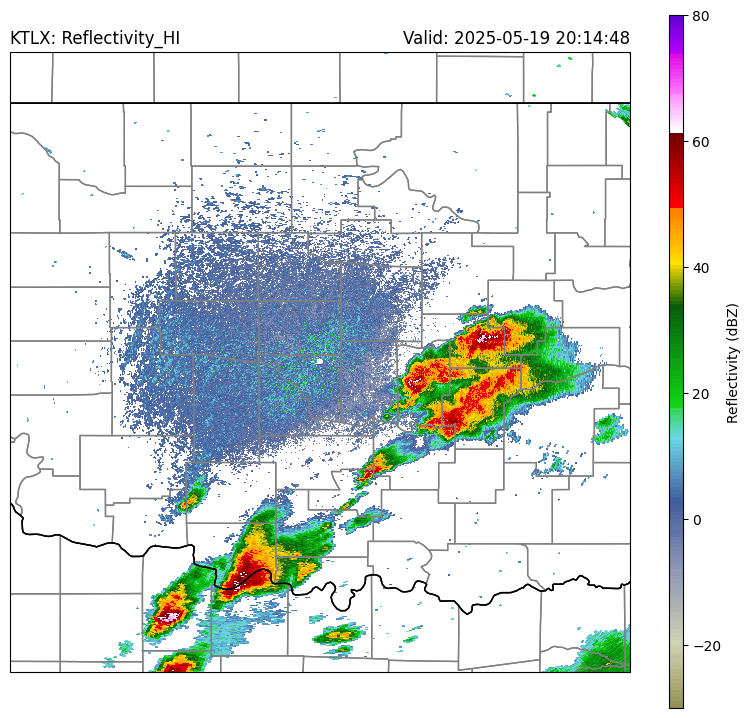

In [16]:
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot radar reflectivity
img = ax.pcolormesh(lon, lat, ref, vmin=-30, vmax=80,
                    cmap=colortables.get_colortable('NWSStormClearReflectivity'),
                    transform=ccrs.PlateCarree())
plt.colorbar(img, ax=ax, aspect=50, pad=0.05, label="Reflectivity (dBZ)")

# Add map features
ax.set_extent([slon-2, slon+2, slat-2, slat+2], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_2_counties', '10m', facecolor='none'), edgecolor='gray')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')

# Add titles
ax.set_title(f'{ds.Station}: {ds.Reflectivity_HI.name}', loc='left')
valid_time = datetime.strptime(ds.time_coverage_start, "%Y-%m-%dT%H:%M:%SZ")
ax.set_title(f'Valid: {valid_time}', loc='right')

plt.show()